In [ ]:
# Install required libraries
!pip install transformers bert-score


In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset paths
train_path = '/content/drive/MyDrive/NLP/project/data/train.csv'
validation_path = '/content/drive/MyDrive/NLP/project/data/validation.csv'
test_path = '/content/drive/MyDrive/NLP/project/data/test.csv'

# Load datasets
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(validation_path)
test_df = pd.read_csv(test_path)

# Display dataset samples
print("\nTrain Dataset Sample:")
print(train_df.head())
print("\nValidation Dataset Sample:")
print(val_df.head())
print("\nTest Dataset Sample:")
print(test_df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Train Dataset Sample:
                                             article  \
0  a recent systematic analysis showed that in 20...   
1  it occurs in more than 50% of patients and may...   
2  tardive dystonia ( td ) , a rarer side effect ...   
3  lepidoptera include agricultural pests that , ...   
4  syncope is caused by transient diffuse cerebra...   

                                            abstract  
0  background : the present study was carried out...  
1  backgroundanemia in patients with cancer who a...  
2  tardive dystonia ( td ) is a serious side effe...  
3  many lepidopteran insects are agricultural pes...  
4  we present an unusual case of recurrent cough ...  

Validation Dataset Sample:
                                             article  \
0  venous thromboembolism ( vte ) comprising of d...   
1  there is an epidemic of stroke in low 

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# Load Pegasus model and tokenizer
model_checkpoint = "google/pegasus-pubmed"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-pubmed and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

PegasusForConditionalGeneration(
  (model): PegasusModel(
    (shared): Embedding(96103, 1024, padding_idx=0)
    (encoder): PegasusEncoder(
      (embed_tokens): Embedding(96103, 1024, padding_idx=0)
      (embed_positions): PegasusSinusoidalPositionalEmbedding(1024, 1024)
      (layers): ModuleList(
        (0-15): 16 x PegasusEncoderLayer(
          (self_attn): PegasusAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_no

In [ ]:
def summarize_texts_in_batches(
    texts, model, tokenizer, batch_size=8, max_input_length=512, max_output_length=150
):
    summaries = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        tokenized_texts = tokenizer(
            batch_texts, max_length=max_input_length, truncation=True, padding=True, return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            batch_summaries = model.generate(
                tokenized_texts["input_ids"],
                max_length=max_output_length,
                min_length=30,
                length_penalty=2.0,
                num_beams=4,
                early_stopping=True,
            )

        decoded_summaries = tokenizer.batch_decode(batch_summaries, skip_special_tokens=True)
        summaries.extend(decoded_summaries)
    return summaries


In [ ]:
# Summarize a sample from the test set
sample_texts = test_df['article'][:100].tolist()  # Adjust sample size as needed
sample_summaries = summarize_texts_in_batches(sample_texts, model, tokenizer, batch_size=4)

# Display a few generated summaries
for i, summary in enumerate(sample_summaries[:5], 1):
    print(f"\nGenerated Summary {i}:")
    print(summary)



Generated Summary 1:
anxiety affects quality of life in those living with parkinson 's disease ( pd ) more so than overall cognitive status , motor deficits , apathy , and depression . <n> although anxiety and depression are often related and coexist in pd patients , recent research suggests that anxiety rather than depression is the most prominent and prevalent mood disorder in pd . yet , our current understanding of anxiety and its impact on cognition in pd , as well as its neural basis and best treatment practices , remains meager and lags far behind that of depression . in this study , we examined whether anxiety differentially affects cognition in patients with left - sided dominant pd ( lpd ) versus right -

Generated Summary 2:
micrornas ( mirnas ) are small non - coding rnas that regulate gene expression and play important roles in the onset and progression of tumorigenesis . emerging evidence demonstrates the involvement of mirna in mammary gland tumorigenesis , functioning e

In [ ]:
from bert_score import score

# Get reference summaries
eval_references = test_df['abstract'][:100].tolist()  # Corresponding references for the test sample

# Compute BERTScore
P, R, F1 = score(sample_summaries, eval_references, lang="en", model_type="bert-base-uncased")

# Display average BERTScore results
print("\nBERTScore Results:")
print(f"Precision: {P.mean().item():.4f}")
print(f"Recall: {R.mean().item():.4f}")
print(f"F1 Score: {F1.mean().item():.4f}")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


BERTScore Results:
Precision: 0.6486
Recall: 0.5992
F1 Score: 0.6211


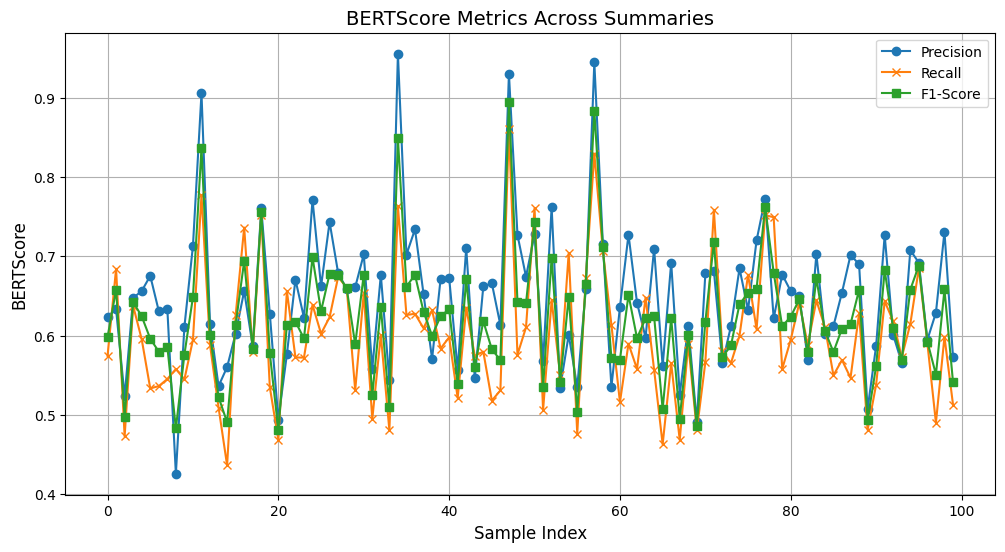

In [ ]:
import matplotlib.pyplot as plt

# Visualize BERTScore metrics
x = range(len(sample_summaries))
plt.figure(figsize=(12, 6))
plt.plot(x, P.tolist(), label='Precision', marker='o')
plt.plot(x, R.tolist(), label='Recall', marker='x')
plt.plot(x, F1.tolist(), label='F1-Score', marker='s')

# Add labels, title, and grid
plt.xlabel("Sample Index", fontsize=12)
plt.ylabel("BERTScore", fontsize=12)
plt.title("BERTScore Metrics Across Summaries", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Save evaluation results to a CSV
results_df = pd.DataFrame({
    "Article": sample_texts,
    "Generated Summary": sample_summaries,
    "Reference Summary": eval_references,
})
results_df.to_csv("/content/drive/MyDrive/NLP/project/bert_score_summaries.csv", index=False)
print("Generated summaries and BERTScore results saved to Google Drive!")


Generated summaries and BERTScore results saved to Google Drive!


In [ ]:
# Summarize a sample from the test set
sample_texts = test_df['article'][:5].tolist()  # Summarize the first 5 articles
sample_references = test_df['abstract'][:5].tolist()  # Corresponding reference summaries
sample_summaries = summarize_texts_in_batches(sample_texts, model, tokenizer, batch_size=2)

# Display one example of the generated summary
print("\nExample of Generated Summary:")
print(f"Original Article:\n{sample_texts[0]}\n")
print(f"Reference Summary:\n{sample_references[0]}\n")
print(f"Generated Summary:\n{sample_summaries[0]}\n")



Example of Generated Summary:
Original Article:
anxiety affects quality of life in those living with parkinson 's disease ( pd ) more so than overall cognitive status , motor deficits , apathy , and depression [ 13 ] . 
 although anxiety and depression are often related and coexist in pd patients , recent research suggests that anxiety rather than depression is the most prominent and prevalent mood disorder in pd [ 5 , 6 ] . yet , 
 our current understanding of anxiety and its impact on cognition in pd , as well as its neural basis and best treatment practices , remains meager and lags far behind that of depression . 
 overall , neuropsychiatric symptoms in pd have been shown to be negatively associated with cognitive performance . 
 for example , higher depression scores have been correlated with lower scores on the mini - mental state exam ( mmse ) [ 8 , 9 ] as well as tests of memory and executive functions ( e.g. , attention ) [ 1014 ] . 
 likewise , apathy and anhedonia in pd pat

In [ ]:
from bert_score import score

# Compute BERTScore for the 5 summaries
P, R, F1 = score(sample_summaries, sample_references, lang="en", model_type="bert-base-uncased")

# Display BERTScore results for the first summary
print("\nBERTScore Results for the First Summary:")
print(f"Precision: {P[0].item():.4f}")
print(f"Recall: {R[0].item():.4f}")
print(f"F1 Score: {F1[0].item():.4f}")



BERTScore Results for the First Summary:
Precision: 0.6239
Recall: 0.5744
F1 Score: 0.5982
